In [1]:
from typing import Tuple
import pandas as pd

from utils.error_metrics import MulticlassErrorMetrics, DatasetCategory

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


def get_set_with_dependend_variabels(df_set: pd.DataFrame, df_dependent) -> pd.DataFrame:
    df = df_set[['Date','Area','mapped_hazard_forecast', 'mapped_hazard_observed']].copy()
    df['Date'] = pd.to_datetime(df['Date']).dt.date
    df_dependent['Date'] = pd.to_datetime(df_dependent['Date']).dt.date
    df = df.merge(df_dependent, on=["Date", "Area"])
    return df

def xy_split(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    return (
        df.drop(columns=["Date", "Area", "mapped_hazard_forecast", "mapped_hazard_observed"]),
        df_train["mapped_hazard_forecast"],
    )


def fit_and_compute_errors(
    model_name: str,
    independent_variables: str,
    pipe: Pipeline,
    sets: dict[DatasetCategory, pd.DataFrame],
    errs: MulticlassErrorMetrics,
):
    training_set = sets[DatasetCategory.TRAINING]
    x, y = xy_split(training_set)
    pipe.fit(x, y)

    for ds_type, ds in sets.items():
        x, _ = xy_split(ds)
        errs.compute_errors(model_name, independent_variables, ds_type, pipe.predict(x))

df_train = pd.read_csv("../data/processed/SAIS_train.csv", index_col=0)
df_dev = pd.read_csv("../data/processed/SAIS_dev.csv", index_col=0)
df_test = pd.read_csv("../data/processed/SAIS_test.csv", index_col=0)
df_train_tab = pd.read_csv(
    "../data/processed/SAIS_train_tabularised.csv", index_col=0
)
df_dev_tab = pd.read_csv(
    "../data/processed/SAIS_dev_tabularised.csv", index_col=0
)
df_test_tab = pd.read_csv(
    "../data/processed/SAIS_test_tabularised.csv", index_col=0
)

df_weather_data_daily_tab = pd.read_csv("../data/proprietary/weather/visual_crossing/weather_days_tabularised.csv")
df_weather_data_48h_then_daily_tab = pd.read_csv("../data/proprietary/weather/visual_crossing/weather_tabularised_48_hours_then_days.csv")

sets_std = {
    DatasetCategory.TRAINING: df_train,
    DatasetCategory.DEVELOPMENT: df_dev,
    DatasetCategory.TEST: df_test,
}

sets_tab = {
    DatasetCategory.TRAINING: df_train_tab,
    DatasetCategory.DEVELOPMENT: df_dev_tab,
    DatasetCategory.TEST: df_test_tab,
}


sets_weather_daily_tab = {
    DatasetCategory.TRAINING: get_set_with_dependend_variabels(df_train, df_weather_data_daily_tab),
    DatasetCategory.DEVELOPMENT: get_set_with_dependend_variabels(df_dev, df_weather_data_daily_tab),
    DatasetCategory.TEST: get_set_with_dependend_variabels(df_test, df_weather_data_daily_tab),
}

sets_weather_48h_then_daily_tab = {
    DatasetCategory.TRAINING: get_set_with_dependend_variabels(df_train, df_weather_data_48h_then_daily_tab),
    DatasetCategory.DEVELOPMENT: get_set_with_dependend_variabels(df_dev, df_weather_data_48h_then_daily_tab),
    DatasetCategory.TEST: get_set_with_dependend_variabels(df_test, df_weather_data_48h_then_daily_tab),
}

In [2]:
most_frequent_value = df_train["mapped_hazard_forecast"].value_counts().index[0]

errs_summary = MulticlassErrorMetrics(
    dataset_name="sais",
    classes=sorted(df_train["mapped_hazard_forecast"].unique()),
    y_true_train=df_train["mapped_hazard_forecast"],
    y_true_dev=df_dev["mapped_hazard_forecast"],
    y_true_test=df_test["mapped_hazard_forecast"],
)

model_name_const = "const"
errs_summary.compute_errors_all_sets(
    model_name_const, "baseline", most_frequent_value, most_frequent_value, most_frequent_value
)
model_name_obs = "observed"
errs_summary.compute_errors_all_sets(
    model_name_obs,
    "baseline",
    df_train["mapped_hazard_observed"],
    df_dev["mapped_hazard_observed"],
    df_test["mapped_hazard_observed"],
)

pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(random_state=1, max_iter=int(1e4))),
    ]
)

model_name_softmax = "softmax regression"
variables_snowprofiles = "snow profiles"
fit_and_compute_errors(
    model_name_softmax, variables_snowprofiles, pipeline, sets_std, errs_summary
)

variables_snowprofiles_whole_season =  "softmax regression (snow profiles across season)"
fit_and_compute_errors(
   model_name_softmax, variables_snowprofiles_whole_season, pipeline, sets_tab, errs_summary
)

variables_weather_daily_whole_season =  "weather daily data across season"
fit_and_compute_errors(
    model_name_softmax, variables_weather_daily_whole_season, pipeline, sets_weather_daily_tab, errs_summary
)

variables_48h_then_daily = "weather 48h hourly then daily data across season"
fit_and_compute_errors(
    model_name_softmax, variables_48h_then_daily, pipeline, sets_weather_48h_then_daily_tab, errs_summary
)

errs_summary.save_assets()


In [3]:
errs_summary.get_error_table_for_set(DatasetCategory.TEST)

,MSE,average error,highest error,accuracy,precision (multiclass),precision (micro),precision (macro),recall (multiclass),recall (micro),recall (macro),$F_1$ (multiclass),$F_1$ (micro),$F_1$ (macro),confusion matrix
"const, baseline",1.629065,-0.895325,-2,0.328252,"[0.0, 0.0, 0.33, 0.0]",0.328252,0.082063,"[0.0, 0.0, 1.0, 0.0]",0.328252,0.25,"[0.0, 0.0, 0.49, 0.0]",0.328252,0.123565,"[[0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 0.0], [..."
"observed, baseline",0.316057,0.137195,2,0.751016,"[0.75, 0.68, 0.84, 0.66]",0.751016,0.730046,"[0.91, 0.64, 0.74, 0.45]",0.751016,0.685227,"[0.82, 0.66, 0.78, 0.53]",0.751016,0.699834,"[[0.910828025477707, 0.08917197452229299, 0.0,..."
"softmax regression, snow profiles",0.528455,0.085366,3,0.617886,"[0.67, 0.5, 0.63, 0.0]",0.617886,0.45324,"[0.8, 0.38, 0.76, 0.0]",0.617886,0.482862,"[0.73, 0.43, 0.69, 0.0]",0.617886,0.463085,"[[0.7993630573248408, 0.15605095541401273, 0.0..."
"softmax regression, softmax regression (snow profiles across season)",1.740854,0.011179,3,0.320122,"[0.34, 0.34, 0.33, 0.08]",0.320122,0.272372,"[0.36, 0.33, 0.3, 0.11]",0.320122,0.274952,"[0.35, 0.34, 0.31, 0.09]",0.320122,0.273021,"[[0.35668789808917195, 0.23885350318471338, 0...."
"softmax regression, weather daily data across season",0.645325,-0.023374,3,0.57622,"[0.7, 0.47, 0.59, 0.43]",0.57622,0.546084,"[0.67, 0.47, 0.6, 0.47]",0.57622,0.551933,"[0.68, 0.47, 0.59, 0.45]",0.57622,0.548745,"[[0.6687898089171974, 0.23885350318471338, 0.0..."
"softmax regression, weather 48h hourly then daily data across season",0.679878,0.001016,-3,0.555894,"[0.68, 0.44, 0.57, 0.38]",0.555894,0.518158,"[0.68, 0.45, 0.57, 0.38]",0.555894,0.517842,"[0.68, 0.44, 0.57, 0.38]",0.555894,0.517996,"[[0.6751592356687898, 0.2229299363057325, 0.09..."


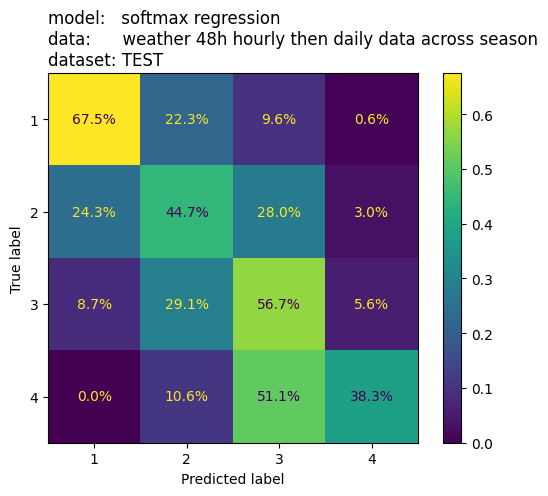

In [4]:
errs_summary.show_confusion_matrix(model_name=model_name_softmax, independent_variables=variables_48h_then_daily, set_cat= DatasetCategory.TEST)